# Практическое задание №6 по теме "Нейросети в обработке текста".

1. Попробуйте обучить нейронную сеть с применением одномерных сверток для предсказания сентимента сообщений с твитера на примере https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech

2. Опишите, какой результат вы получили? Что помогло вам улучшить ее точность?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

from tqdm import tqdm 
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

### Загрузка данных

In [2]:
df = pd.read_csv("data/Twitter_Sentiment_Analysis/train.csv")

Так как в файле test.csv отсутствует целевой признак для валидации, возьмем файл train.csv и разделим его на тренировочную и валидационную выборки:

In [3]:
train_df, val_df = train_test_split(df, test_size=0.20, random_state=42)

In [4]:
train_df.head()

,id,label,tweet
12110,12111,1,@user @user @user because i've been paying att...
14081,14082,0,@user raft building at salford quays as pa of...
1829,1830,0,friday ð ð» #gdegblog #friday #selfie #b...
2769,2770,0,#fashion it is a true #fact
31818,31819,0,"so to #share the #simple, #elegant #business..."


In [5]:
val_df.head()

,id,label,tweet
12227,12228,0,@user âmy mom says my smile is captivatingâ...
14709,14710,0,"in 3 days i will be meeting my sis-n-law, coun..."
19319,19320,0,hating the conservative homophobes using this ...
4308,4309,0,awee if this doesn't #scream #friday #acewe...
24055,24056,0,fathersday #fatherÃ¢ÂÂs #day #god! #ÃÂ« #...


Присутствует дисбаланс классов:

In [6]:
train_df['label'].value_counts()

0    23783
1     1786
Name: label, dtype: int64

In [7]:
val_df['label'].value_counts()

0    5937
1     456
Name: label, dtype: int64

### Обработка

In [8]:
max_words = 2000
max_len = 20
num_classes = 1

In [9]:
sw = set(get_stop_words("en"))

In [10]:
puncts = set(punctuation)
puncts

{'!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~'}

In [11]:
morpher = MorphAnalyzer()


def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in puncts)
    txt = txt.lower()
    txt = re.sub("не\s", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

In [12]:
tqdm.pandas()

train_df['tweet'] = train_df['tweet'].progress_apply(preprocess_text)
val_df['tweet'] = val_df['tweet'].progress_apply(preprocess_text)

100%|████████████████████████████████████████████████████████████████████████████| 6393/6393 [00:01<00:00, 6352.23it/s]


In [13]:
train_corpus = " ".join(train_df["tweet"])
train_corpus = train_corpus.lower()

In [14]:
nltk.download("punkt")

tokens = word_tokenize(train_corpus)
tokens[:5]

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pakhomov\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['user', 'user', 'user', 'ive', 'paying']

In [15]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [16]:
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]  # вычитание 1 для padding
len(tokens_filtered_top)

1999

In [17]:
tokens_filtered_top[:10]

['user', 'love', 'day', 'happy', 'amp', 'just', 'will', 'im', 'u', 'life']

In [18]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [19]:
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])

    padding = [0] * (maxlen-len(result))
    return result[-maxlen:] + padding

In [20]:
%%time
x_train = np.asarray([text_to_sequence(text, max_len) for text in train_df["tweet"]])
x_val = np.asarray([text_to_sequence(text, max_len) for text in val_df["tweet"]])

CPU times: total: 2.34 s
Wall time: 2.33 s


### Построение сети и обучение

In [21]:
epochs = 15
batch_size = 512
print_batch_n = 100

In [22]:
class Net(nn.Module):
    def __init__(self, vocab_size=2000, embedding_dim=128, out_channel=128, num_classes=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_1 = nn.Conv1d(embedding_dim, out_channel, kernel_size=2)
        self.conv_2 = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.pool = nn.MaxPool1d(2)
        self.relu = nn.ReLU()
        self.linear_1 = nn.Linear(out_channel, out_channel // 2)
        self.linear_2 = nn.Linear(out_channel // 2, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x) # B, L, E
        #                       B  E  L         
        output = output.permute(0, 2, 1)
        output = self.conv_1(output)
        output = self.relu(output)
        output = self.pool(output)

        output = self.conv_2(output)
        output = self.relu(output)
        output = self.pool(output)
        output = torch.max(output, axis=2).values
        output = self.linear_1(output)
        output = self.relu(output)
        output = self.linear_2(output)
        output = torch.sigmoid(output)
        return output

In [23]:
class DataWrapper(Dataset):
    def __init__(self, data, target, transform=None):
        self.data = torch.from_numpy(data).long()
        self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [24]:
train_dataset = DataWrapper(x_train, train_df['label'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, val_df['label'].values)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

In [25]:
model = Net(vocab_size=max_words)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [26]:
print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

Net(
  (embedding): Embedding(2000, 128)
  (conv_1): Conv1d(128, 128, kernel_size=(2,), stride=(1,))
  (conv_2): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear_1): Linear(in_features=128, out_features=64, bias=True)
  (linear_2): Linear(in_features=64, out_features=1, bias=True)
)
Parameters: 346497


In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.BCELoss()

In [28]:
model = model.to(device)
model.train()
th = 0.5

train_loss_history = []
test_loss_history = []


for epoch in range(epochs):  
    running_items, running_right = 0.0, 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # обнуляем градиент
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, labels.float().view(-1, 1))
        loss.backward()
        optimizer.step()

        # подсчет ошибки на обучении
        loss = loss.item()
        running_items += len(labels)
        # подсчет метрики на обучении
        pred_labels = torch.squeeze((outputs > th).int())
        running_right += (labels == pred_labels).sum()
        
    # выводим статистику о процессе обучения
    model.eval()
    
    print(f'Epoch [{epoch + 1}/{epochs}]. ' \
            f'Step [{i + 1}/{len(train_loader)}]. ' \
            f'Loss: {loss:.3f}. ' \
            f'Acc: {running_right / running_items:.3f}', end='. ')
    running_loss, running_items, running_right = 0.0, 0.0, 0.0
    train_loss_history.append(loss)

        # выводим статистику на тестовых данных
    test_running_right, test_running_total, test_loss = 0.0, 0.0, 0.0
    for j, data in enumerate(val_loader):
        test_labels = data[1].to(device)
        test_outputs = model(data[0].to(device))
        
        # подсчет ошибки на тесте
        test_loss = criterion(test_outputs, test_labels.float().view(-1, 1))
        # подсчет метрики на тесте
        test_running_total += len(data[1])
        pred_test_labels = torch.squeeze((test_outputs > th).int())
        test_running_right += (test_labels == pred_test_labels).sum()
    
    test_loss_history.append(test_loss.item())
    print(f'Test loss: {test_loss:.3f}. Test acc: {test_running_right / test_running_total:.3f}')
    
    model.train()
        
print('Training is finished!')

Epoch [1/15]. Step [50/50]. Loss: 0.204. Acc: 0.929. Test loss: 0.086. Test acc: 0.931
Epoch [2/15]. Step [50/50]. Loss: 0.117. Acc: 0.948. Test loss: 0.008. Test acc: 0.948
Epoch [3/15]. Step [50/50]. Loss: 0.133. Acc: 0.964. Test loss: 0.000. Test acc: 0.949
Epoch [4/15]. Step [50/50]. Loss: 0.050. Acc: 0.975. Test loss: 0.000. Test acc: 0.950
Epoch [5/15]. Step [50/50]. Loss: 0.034. Acc: 0.984. Test loss: 0.000. Test acc: 0.943
Epoch [6/15]. Step [50/50]. Loss: 0.053. Acc: 0.989. Test loss: 0.000. Test acc: 0.946
Epoch [7/15]. Step [50/50]. Loss: 0.028. Acc: 0.991. Test loss: 0.000. Test acc: 0.944
Epoch [8/15]. Step [50/50]. Loss: 0.016. Acc: 0.992. Test loss: 0.000. Test acc: 0.940
Epoch [9/15]. Step [50/50]. Loss: 0.008. Acc: 0.993. Test loss: 0.000. Test acc: 0.937
Epoch [10/15]. Step [50/50]. Loss: 0.020. Acc: 0.996. Test loss: 0.000. Test acc: 0.936
Epoch [11/15]. Step [50/50]. Loss: 0.016. Acc: 0.996. Test loss: 0.000. Test acc: 0.942
Epoch [12/15]. Step [50/50]. Loss: 0.023.

Построим динамику обучения:

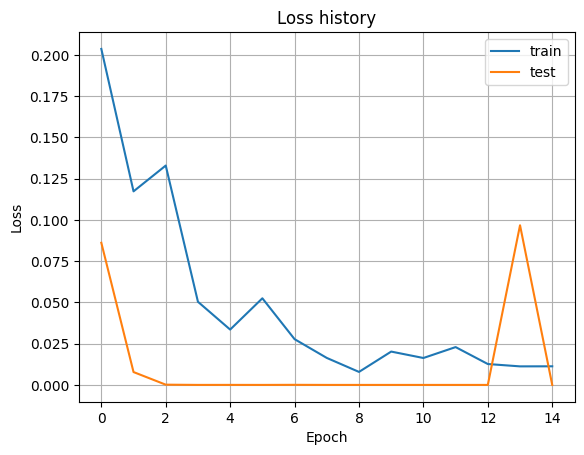

In [31]:
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(train_loss_history, label='train')
plt.plot(test_loss_history, label='test')
plt.legend();

**Вывод:** Увеличение количества эпох с 5 до 15 оказалось избыточным. По графику видно, что тестовые потери свелись к нулю начиная с 2-й эпохи, однако тренировочная выборка вышла на плато только к 8-й. После 8 эпохи началось переобучение.

---